<a href="https://colab.research.google.com/github/codeslayr/Neural_Network_Optimization/blob/main/cnn_hyperparameter_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import random
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


NUM_SEARCH_TRIALS = 20
FINAL_TRAINING_EPOCHS = 10
GA_POP_SIZE = 10
GA_GENERATIONS = 20
PSO_PARTICLES = 10
PSO_GENERATIONS = 20

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seeds()

Using device: cuda


**DATA LOADING**

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Full datasets
full_train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# Split for validation
train_ds, val_ds = random_split(full_train_dataset, [55000, 5000])

# Subset for faster hyperparameter search
search_train_subset = Subset(train_ds, list(range(5000)))

# DataLoaders
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
CLASS_NAMES = test_dataset.classes

100%|██████████| 26.4M/26.4M [00:00<00:00, 111MB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.91MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 61.3MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 6.63MB/s]


**MODEL DEFINITIONS**

In [ ]:
class FashionCNN(nn.Module):
    """Fixed architecture for Adam, SGD, L-BFGS."""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(), nn.Linear(64 * 7 * 7, 128), nn.ReLU(), nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.net(x)

class CustomCNN(nn.Module):
    """Variable architecture for GA, PSO."""
    def __init__(self, conv1_out, conv2_out, fc_units):
        super().__init__()
        self.conv1 = nn.Conv2d(1, int(conv1_out), 3, padding=1)
        self.conv2 = nn.Conv2d(int(conv1_out), int(conv2_out), 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten_size = int(conv2_out * 7 * 7)
        self.fc1 = nn.Linear(self.flatten_size, int(fc_units))
        self.fc2 = nn.Linear(int(fc_units), 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.flatten_size)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

**CORE UTILITIES**

In [ ]:
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, dataloader, optimizer, use_closure=False, wd=0.0):
    """Trains the model for one epoch."""
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X, y in dataloader:
        X, y = X.to(DEVICE), y.to(DEVICE)

        def closure():
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            if wd > 0:
                l2_reg = sum(p.pow(2).sum() for p in model.parameters())
                loss += wd * l2_reg
            loss.backward()
            return loss

        if use_closure:
            loss = optimizer.step(closure)
        else:
            loss = closure()
            optimizer.step()

        with torch.no_grad():
            total_loss += loss.item() * y.size(0)
            preds = model(X).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return total_loss / total, correct / total

def evaluate_and_get_metrics(model, dataloader):
    """Evaluates the model and returns loss, accuracy, and predictions."""
    model.eval()
    all_preds, all_labels = [], []
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            out = model(X)
            loss = criterion(out, y)

            total_loss += loss.item() * y.size(0)
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / total
    avg_acc = correct / total

    report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES, output_dict=True, zero_division=0)

    metrics = {
        'loss': avg_loss,
        'accuracy': avg_acc,
        'report': report,
        'y_true': all_labels,
        'y_pred': all_preds
    }
    return metrics

**OPTIMIZER EXPERIMENT FUNCTIONS**

In [ ]:
def run_adam_experiment():
    print("\n--- Running Adam (Baseline) ---")
    set_seeds()
    model = FashionCNN().to(DEVICE)
    # Using a less-optimal LR to show the value of hyperparameter tuning.
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    full_train_loader = DataLoader(full_train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(FINAL_TRAINING_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, full_train_loader, optimizer)
        val_metrics = evaluate_and_get_metrics(model, val_loader)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        print(f"Epoch {epoch+1}/{FINAL_TRAINING_EPOCHS} -> Train Acc: {train_acc:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")

    test_metrics = evaluate_and_get_metrics(model, test_loader)
    print(f"\n✅ Adam Final Results -> Test Loss: {test_metrics['loss']:.4f}, Test Acc: {test_metrics['accuracy']:.4f}")
    return {'model': model, 'history': history, 'test_metrics': test_metrics}

def run_sgd_experiment():
    print("\n--- Running SGD with Random Search ---")
    search_space = {
        'lr': lambda: 10**np.random.uniform(-4, -1),
        'momentum': lambda: np.random.uniform(0.5, 0.99),
        'batch_size': lambda: random.choice([32, 64, 128]),
        'weight_decay': lambda: 10**np.random.uniform(-5, -2)
    }

    # Search Phase
    print("Running search phase...")
    best_config, best_val_acc = None, -1
    val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)
    for i in range(NUM_SEARCH_TRIALS):
        set_seeds(i)
        config = {k: fn() for k, fn in search_space.items()}
        model = FashionCNN().to(DEVICE)
        optimizer = optim.SGD(model.parameters(), **{k:v for k,v in config.items() if k != 'batch_size'})
        search_loader = DataLoader(search_train_subset, batch_size=int(config['batch_size']), shuffle=True)
        train_one_epoch(model, search_loader, optimizer)
        val_metrics = evaluate_and_get_metrics(model, val_loader)
        if val_metrics['accuracy'] > best_val_acc:
            best_val_acc = val_metrics['accuracy']
            best_config = config
        print(f"Trial [{i+1}/{NUM_SEARCH_TRIALS}] - Acc: {val_metrics['accuracy']:.4f}, Loss: {val_metrics['loss']:.4f}, Config: {config}")

    print(f"\nSearch complete. Best params found: {best_config}")

    # Final Training
    print("Running final training with best params...")
    set_seeds()
    model = FashionCNN().to(DEVICE)
    optimizer = optim.SGD(model.parameters(), **{k:v for k,v in best_config.items() if k != 'batch_size'})
    full_train_loader = DataLoader(full_train_dataset, batch_size=int(best_config['batch_size']), shuffle=True)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(FINAL_TRAINING_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, full_train_loader, optimizer)
        val_metrics = evaluate_and_get_metrics(model, val_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        print(f"Epoch {epoch+1}/{FINAL_TRAINING_EPOCHS} -> Train Acc: {train_acc:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")

    test_metrics = evaluate_and_get_metrics(model, test_loader)
    print(f"\n✅ SGD Final Results -> Test Loss: {test_metrics['loss']:.4f}, Test Acc: {test_metrics['accuracy']:.4f}")
    return {'model': model, 'history': history, 'test_metrics': test_metrics}

def run_lbfgs_experiment():
    print("\n--- Running L-BFGS with Random Search ---")
    search_space = {
        'lr': lambda: 10**np.random.uniform(-2, 0),
        'batch_size': lambda: random.choice([256, 512, 1024]),
        'weight_decay': lambda: 10**np.random.uniform(-5, -2)
    }

    # Search Phase
    print("Running search phase...")
    best_config, best_val_acc = None, -1
    val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)
    for i in range(NUM_SEARCH_TRIALS):
        set_seeds(i)
        config = {k: fn() for k, fn in search_space.items()}
        model = FashionCNN().to(DEVICE)
        optimizer = optim.LBFGS(model.parameters(), lr=config['lr'], max_iter=10)
        search_loader = DataLoader(search_train_subset, batch_size=int(config['batch_size']), shuffle=True)
        train_one_epoch(model, search_loader, optimizer, use_closure=True, wd=config['weight_decay'])
        val_metrics = evaluate_and_get_metrics(model, val_loader)
        if val_metrics['accuracy'] > best_val_acc:
            best_val_acc = val_metrics['accuracy']
            best_config = config
        print(f"Trial [{i+1}/{NUM_SEARCH_TRIALS}] - Acc: {val_metrics['accuracy']:.4f}, Loss: {val_metrics['loss']:.4f}, Config: {config}")

    print(f"\nSearch complete. Best params found: {best_config}")

    # Final Training
    print("Running final training with best params...")
    set_seeds()
    model = FashionCNN().to(DEVICE)
    full_train_loader = DataLoader(full_train_dataset, batch_size=int(best_config['batch_size']), shuffle=True)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(FINAL_TRAINING_EPOCHS):
        optimizer = optim.LBFGS(model.parameters(), lr=best_config['lr'], max_iter=20, line_search_fn="strong_wolfe")
        train_loss, train_acc = train_one_epoch(model, full_train_loader, optimizer, use_closure=True, wd=best_config['weight_decay'])
        val_metrics = evaluate_and_get_metrics(model, val_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        print(f"Epoch {epoch+1}/{FINAL_TRAINING_EPOCHS} -> Train Acc: {train_acc:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")

    test_metrics = evaluate_and_get_metrics(model, test_loader)
    print(f"\n✅ L-BFGS Final Results -> Test Loss: {test_metrics['loss']:.4f}, Test Acc: {test_metrics['accuracy']:.4f}")
    return {'model': model, 'history': history, 'test_metrics': test_metrics}

def run_ga_experiment():
    print("\n--- Running Genetic Algorithm (GA) Search ---")
    param_bounds = {"lr": [1e-4, 1e-2], "conv1_out": [16, 64], "conv2_out": [32, 128], "fc_units": [64, 256]}
    def random_gene():
        return {"lr": 10**random.uniform(-4, -2), "conv1_out": random.randint(16, 64),
                "conv2_out": random.randint(32, 128), "fc_units": random.randint(64, 256)}

    # Search Phase
    print("Running search phase...")
    population = [random_gene() for _ in range(GA_POP_SIZE)]
    best_gene, best_val_acc = None, -1
    val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)
    for gen in range(GA_GENERATIONS):
        scored_pop = []
        for gene in population:
            set_seeds(gen)
            model_params = {k: gene[k] for k in ['conv1_out', 'conv2_out', 'fc_units']}
            model = CustomCNN(**model_params).to(DEVICE)
            optimizer = optim.Adam(model.parameters(), lr=gene['lr'])
            search_loader = DataLoader(search_train_subset, batch_size=64, shuffle=True)
            train_one_epoch(model, search_loader, optimizer)
            val_metrics = evaluate_and_get_metrics(model, val_loader)
            scored_pop.append({'acc': val_metrics['accuracy'], 'loss': val_metrics['loss'], 'gene': gene})

        scored_pop.sort(key=lambda x: x['acc'], reverse=True)
        best_of_gen = scored_pop[0]
        if best_of_gen['acc'] > best_val_acc:
            best_val_acc = best_of_gen['acc']
            best_gene = best_of_gen['gene']

        print(f"Gen [{gen+1}/{GA_GENERATIONS}] -> Best Acc: {best_of_gen['acc']:.4f}, Loss: {best_of_gen['loss']:.4f}, Config: {best_of_gen['gene']}")

        top_genes = [g['gene'] for g in scored_pop[:GA_POP_SIZE//2]]
        new_pop = top_genes[:]
        while len(new_pop) < GA_POP_SIZE:
            p1, p2 = random.sample(top_genes, 2)
            child = {k: p1[k] if random.random() < 0.5 else p2[k] for k in p1}
            new_pop.append(child)
        population = new_pop

    print(f"\nSearch complete. Best gene found: {best_gene}")

    # Final Training
    print("Running final training with best gene...")
    set_seeds()
    final_model_params = {k: best_gene[k] for k in ['conv1_out', 'conv2_out', 'fc_units']}
    model = CustomCNN(**final_model_params).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=best_gene['lr'])
    full_train_loader = DataLoader(full_train_dataset, batch_size=64, shuffle=True)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(FINAL_TRAINING_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, full_train_loader, optimizer)
        val_metrics = evaluate_and_get_metrics(model, val_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        print(f"Epoch {epoch+1}/{FINAL_TRAINING_EPOCHS} -> Train Acc: {train_acc:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")

    test_metrics = evaluate_and_get_metrics(model, test_loader)
    print(f"\n✅ GA Final Results -> Test Loss: {test_metrics['loss']:.4f}, Test Acc: {test_metrics['accuracy']:.4f}")
    return {'model': model, 'history': history, 'test_metrics': test_metrics}

def run_pso_experiment():
    print("\n--- Running Particle Swarm Optimization (PSO) ---")
    param_bounds = {"lr": [1e-4, 1e-2], "conv1_out": [16, 64], "conv2_out": [32, 128], "fc_units": [64, 256]}
    def init_particle():
        return {"lr": 10**random.uniform(-4, -2), "conv1_out": random.uniform(16, 64),
                "conv2_out": random.uniform(32, 128), "fc_units": random.uniform(64, 256)}
    def to_int_params(p):
        return {k: (v if k == 'lr' else int(v)) for k,v in p.items()}

    # Search Phase
    print("Running search phase...")
    particles = [init_particle() for _ in range(PSO_PARTICLES)]
    velocities = [{k: 0 for k in p} for p in particles]
    personal_best_pos = deepcopy(particles)
    personal_best_scores = [float('inf')] * PSO_PARTICLES
    global_best_pos, global_best_score = None, float('inf')
    val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)

    for gen in range(PSO_GENERATIONS):
        for i, p in enumerate(particles):
            int_params = to_int_params(p)
            model_params = {k: int_params[k] for k in ['conv1_out', 'conv2_out', 'fc_units']}
            model = CustomCNN(**model_params).to(DEVICE)
            optimizer = optim.Adam(model.parameters(), lr=p['lr'])
            search_loader = DataLoader(search_train_subset, batch_size=64, shuffle=True)
            train_one_epoch(model, search_loader, optimizer)
            score = evaluate_and_get_metrics(model, val_loader)['loss']
            if score < personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best_pos[i] = deepcopy(p)
            if score < global_best_score:
                global_best_score = score
                global_best_pos = deepcopy(p)

        global_best_int_params = to_int_params(global_best_pos)
        current_acc = evaluate_and_get_metrics(model, val_loader)['accuracy']
        print(f"Gen [{gen+1}/{PSO_GENERATIONS}] -> Best Acc: {current_acc:.4f}, Loss: {global_best_score:.4f}, Config: {global_best_int_params}")

        w, c1, c2 = 0.5, 1.5, 1.5
        for i, p in enumerate(particles):
            for k in p:
                r1, r2 = random.random(), random.random()
                velocities[i][k] = (w*velocities[i][k] + c1*r1*(personal_best_pos[i][k] - p[k]) + c2*r2*(global_best_pos[k] - p[k]))
                p[k] += velocities[i][k]
                p[k] = np.clip(p[k], *param_bounds[k])

    best_params = to_int_params(global_best_pos)
    print(f"\nSearch complete. Best params found: {best_params}")

    # Final Training
    print("Running final training with best params...")
    set_seeds()
    final_model_params = {k: best_params[k] for k in ['conv1_out', 'conv2_out', 'fc_units']}
    model = CustomCNN(**final_model_params).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
    full_train_loader = DataLoader(full_train_dataset, batch_size=64, shuffle=True)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(FINAL_TRAINING_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, full_train_loader, optimizer)
        val_metrics = evaluate_and_get_metrics(model, val_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        print(f"Epoch {epoch+1}/{FINAL_TRAINING_EPOCHS} -> Train Acc: {train_acc:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")

    test_metrics = evaluate_and_get_metrics(model, test_loader)
    print(f"\n✅ PSO Final Results -> Test Loss: {test_metrics['loss']:.4f}, Test Acc: {test_metrics['accuracy']:.4f}")
    return {'model': model, 'history': history, 'test_metrics': test_metrics}

**PLOTTING FUNCTIONS**

In [ ]:
def generate_individual_optimizer_reports(results_archive):
    """
    For each optimizer, generates a single figure with all individual plots
    and prints the text-based classification report.
    """
    for name, results in results_archive.items():
        print(f"\n{'='*20} Full Report for: {name} {'='*20}")

        # --- Create a single figure with 4 subplots ---
        fig, axes = plt.subplots(2, 2, figsize=(18, 14))
        fig.suptitle(f'Comprehensive Analysis for {name} Optimizer', fontsize=20)

        history = results['history']
        metrics = results['test_metrics']
        epochs = range(1, len(history['train_loss']) + 1)

        # 1. Loss Learning Curve (Top-Left)
        ax1 = axes[0, 0]
        ax1.plot(epochs, history['train_loss'], 'o-', label='Training Loss')
        ax1.plot(epochs, history['val_loss'], 's--', label='Validation Loss')
        ax1.set_title('Loss over Epochs')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # 2. Accuracy Learning Curve (Top-Right)
        ax2 = axes[0, 1]
        ax2.plot(epochs, history['train_acc'], 'o-', label='Training Accuracy')
        ax2.plot(epochs, history['val_acc'], 's--', label='Validation Accuracy')
        ax2.set_title('Accuracy over Epochs')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        ax2.set_ylim(0, 1.05)

        # 3. Confusion Matrix (Bottom-Left)
        ax3 = axes[1, 0]
        y_true, y_pred = metrics['y_true'], metrics['y_pred']
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax3)
        ax3.set_title('Confusion Matrix on Test Set')
        ax3.set_xlabel('Predicted Label')
        ax3.set_ylabel('True Label')

        # 4. Precision, Recall, F1-Score Bar Chart (Bottom-Right)
        ax4 = axes[1, 1]
        report_df = pd.DataFrame(metrics['report']).iloc[:-1, :].T
        report_df.drop(columns=['accuracy', 'macro avg', 'weighted avg'], inplace=True, errors='ignore')
        report_df.plot(kind='bar', ax=ax4, width=0.8)
        ax4.set_title('Precision, Recall, & F1-Score per Class')
        ax4.set_ylabel('Score')

        # --- FIX IS HERE ---
        # Use set_xticklabels() for rotation and alignment instead of tick_params()
        ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
        # --- END FIX ---

        ax4.set_ylim(0, 1.1)
        ax4.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # --- Print the text-based classification report ---
        print("\n--- Text-Based Classification Report ---")
        report_text = classification_report(
            metrics['y_true'],
            metrics['y_pred'],
            target_names=CLASS_NAMES,
            digits=2
        )
        print(report_text)
        print(f"{'='*58}")

def plot_comparative_results(results_archive):
    """Plots bar charts comparing the final accuracy and loss of all optimizers."""
    df_data = []
    for name, results in results_archive.items():
        df_data.append({
            'Optimizer': name,
            'Accuracy': results['test_metrics']['accuracy'],
            'Loss': results['test_metrics']['loss']
        })
    df = pd.DataFrame(df_data)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Accuracy Plot
    sns.barplot(x='Optimizer', y='Accuracy', data=df, ax=axes[0], palette='viridis', hue='Optimizer', dodge=False)
    axes[0].set_title('Comparative Test Accuracy (Bar)')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_ylim(bottom=max(0, df['Accuracy'].min() * 0.95))
    for container in axes[0].containers:
        axes[0].bar_label(container, fmt='%.4f')

    # Loss Plot
    sns.barplot(x='Optimizer', y='Loss', data=df, ax=axes[1], palette='plasma', hue='Optimizer', dodge=False)
    axes[1].set_title('Comparative Test Loss (Bar)')
    axes[1].set_ylabel('Loss')
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt='%.4f')

    plt.suptitle('Final Performance Comparison', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_comparative_lines(results_archive):
    """Plots line graphs comparing the final test accuracy and loss of all optimizers."""
    df_data = []
    for name, results in results_archive.items():
        df_data.append({
            'Optimizer': name,
            'Accuracy': results['test_metrics']['accuracy'],
            'Loss': results['test_metrics']['loss']
        })
    df = pd.DataFrame(df_data)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    plt.suptitle('Final Performance Comparison (Line Plot)', fontsize=16)

    # Accuracy Line Plot
    sns.lineplot(x='Optimizer', y='Accuracy', data=df, ax=axes[0], marker='o', sort=False, color='b')
    axes[0].set_title('Comparative Test Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].grid(True, linestyle='--', alpha=0.6)
    for i, point in df.iterrows():
        axes[0].text(point['Optimizer'], point['Accuracy'] + 0.005, f"{point['Accuracy']:.4f}", ha='center')

    # Loss Line Plot
    sns.lineplot(x='Optimizer', y='Loss', data=df, ax=axes[1], marker='o', color='r', sort=False)
    axes[1].set_title('Comparative Test Loss')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True, linestyle='--', alpha=0.6)
    for i, point in df.iterrows():
        axes[1].text(point['Optimizer'], point['Loss'] + 0.01, f"{point['Loss']:.4f}", ha='center')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_all_learning_curves_combined(results_archive):
    """
    Plots the validation accuracy and loss curves for ALL optimizers on a single graph.
    """
    history_data = []
    for name, results in results_archive.items():
        history = results['history']
        epochs = range(1, len(history.get('val_loss', [])) + 1)
        for epoch, val_loss, val_acc in zip(epochs, history['val_loss'], history['val_acc']):
            history_data.append({
                'Optimizer': name,
                'Epoch': epoch,
                'Validation Loss': val_loss,
                'Validation Accuracy': val_acc
            })
    df_history = pd.DataFrame(history_data)

    if df_history.empty:
        print("No history data to plot for combined learning curves.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    plt.suptitle('Comparative Learning Dynamics over Epochs', fontsize=16)

    # Accuracy Plot
    sns.lineplot(data=df_history, x='Epoch', y='Validation Accuracy', hue='Optimizer', marker='o', ax=axes[0])
    axes[0].set_title('Validation Accuracy over Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].grid(True, linestyle='--')
    axes[0].legend(title='Optimizer')
    axes[0].get_xaxis().set_major_locator(plt.MaxNLocator(integer=True))

    # Loss Plot
    sns.lineplot(data=df_history, x='Epoch', y='Validation Loss', hue='Optimizer', marker='o', ax=axes[1])
    axes[1].set_title('Validation Loss over Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True, linestyle='--')
    axes[1].legend(title='Optimizer')
    axes[1].get_xaxis().set_major_locator(plt.MaxNLocator(integer=True))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

**MAIN EXECUTION**


--- Running Adam (Baseline) ---
Epoch 1/10 -> Train Acc: 0.8518, Val Acc: 0.8806
Epoch 2/10 -> Train Acc: 0.8942, Val Acc: 0.8830
Epoch 3/10 -> Train Acc: 0.9019, Val Acc: 0.8980
Epoch 4/10 -> Train Acc: 0.9066, Val Acc: 0.8994
Epoch 5/10 -> Train Acc: 0.9086, Val Acc: 0.9064
Epoch 6/10 -> Train Acc: 0.9141, Val Acc: 0.9078
Epoch 7/10 -> Train Acc: 0.9145, Val Acc: 0.9054
Epoch 8/10 -> Train Acc: 0.9159, Val Acc: 0.9046
Epoch 9/10 -> Train Acc: 0.9179, Val Acc: 0.9120
Epoch 10/10 -> Train Acc: 0.9192, Val Acc: 0.9148

✅ Adam Final Results -> Test Loss: 0.3513, Test Acc: 0.8857

--- Running SGD with Random Search ---
Running search phase...
Trial [1/20] - Acc: 0.5288, Loss: 1.0890, Config: {'lr': 0.004430375245218264, 'momentum': 0.8504427895224855, 'batch_size': 64, 'weight_decay': 0.0006431172050131989}
Trial [2/20] - Acc: 0.5584, Loss: 1.3730, Config: {'lr': 0.001782649715138694, 'momentum': 0.8529590017866575, 'batch_size': 32, 'weight_decay': 1.0007903854383773e-05}
Trial [3/20] -

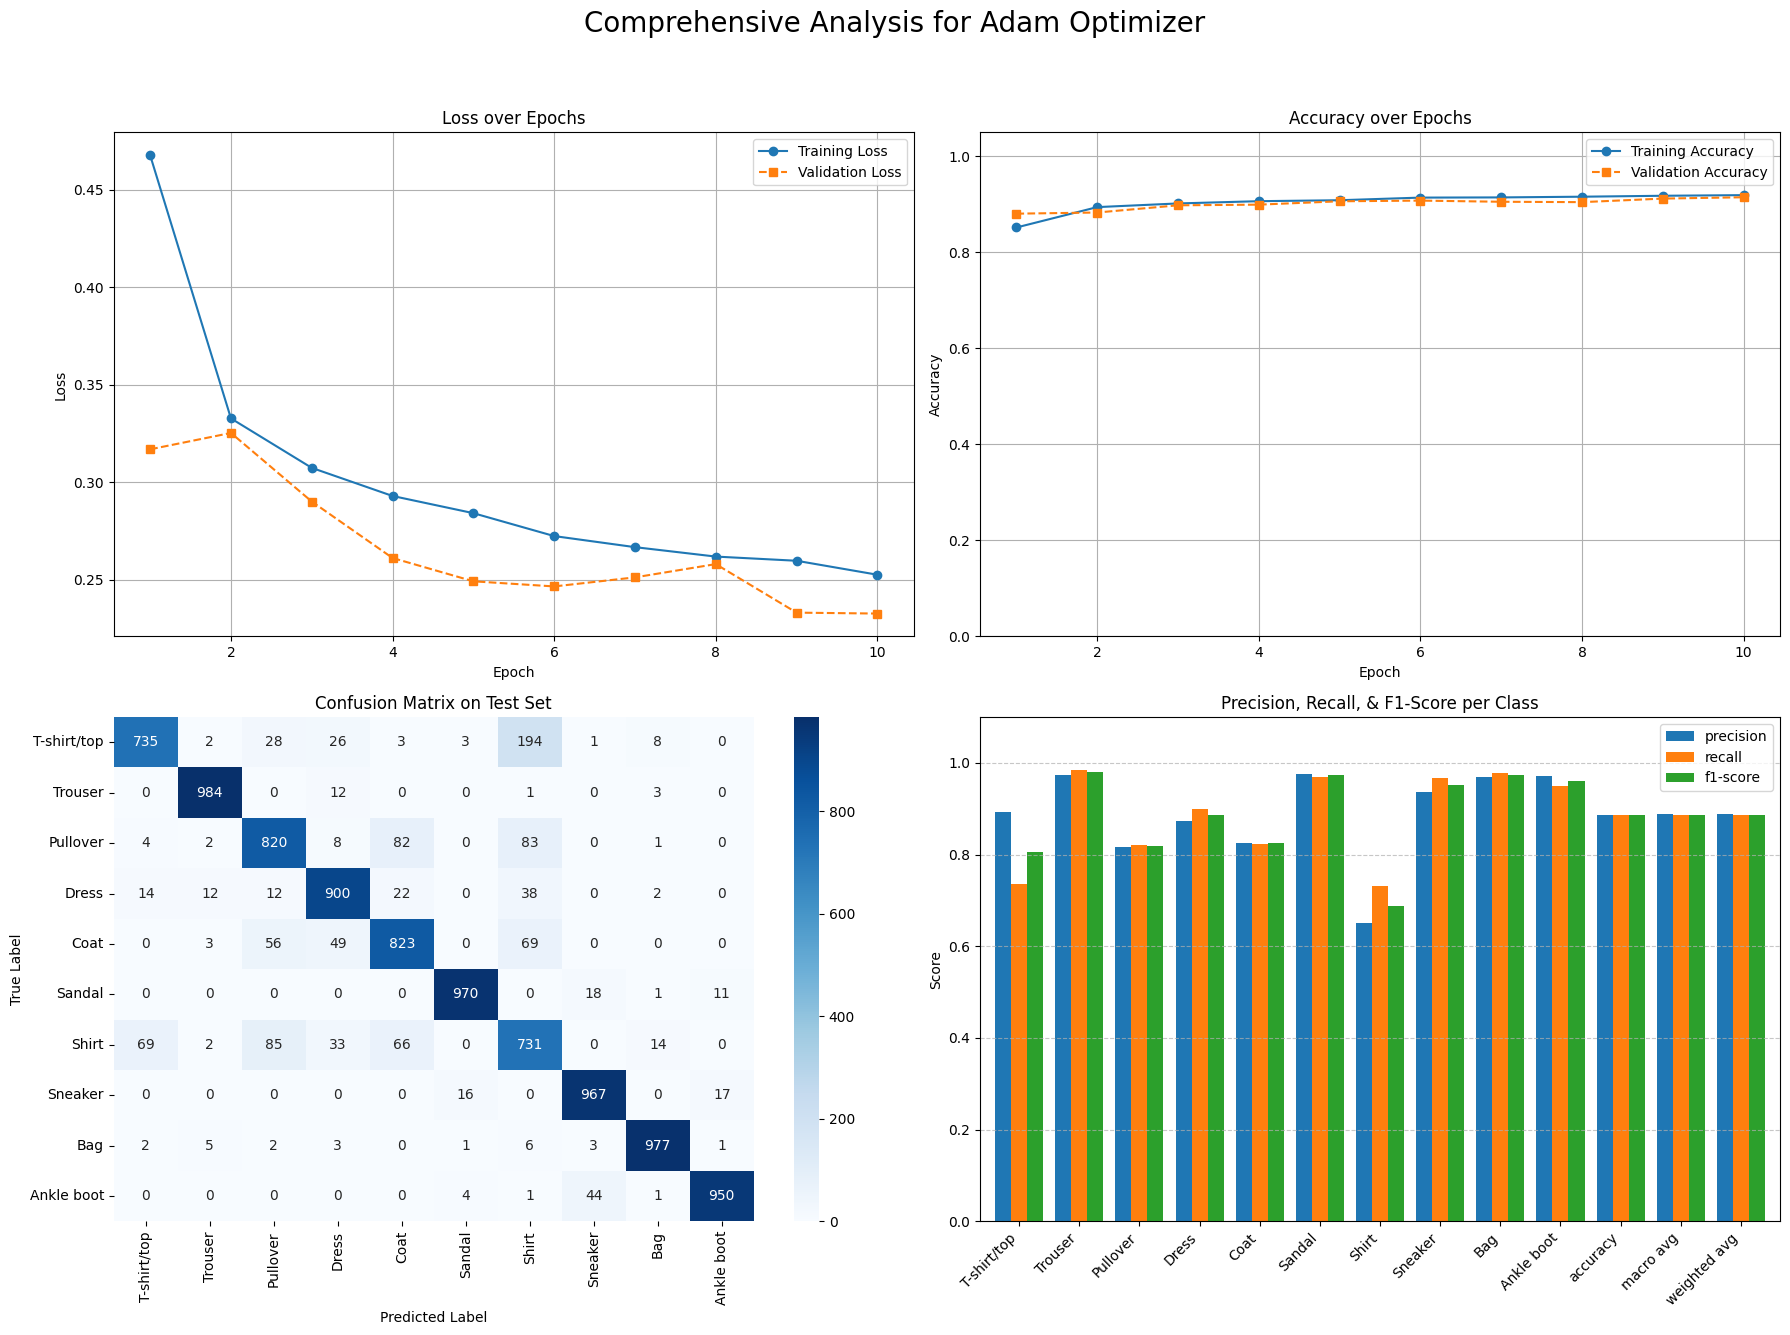


--- Text-Based Classification Report ---
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.73      0.81      1000
     Trouser       0.97      0.98      0.98      1000
    Pullover       0.82      0.82      0.82      1000
       Dress       0.87      0.90      0.89      1000
        Coat       0.83      0.82      0.82      1000
      Sandal       0.98      0.97      0.97      1000
       Shirt       0.65      0.73      0.69      1000
     Sneaker       0.94      0.97      0.95      1000
         Bag       0.97      0.98      0.97      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


==================== Full Report for: SGD ====================


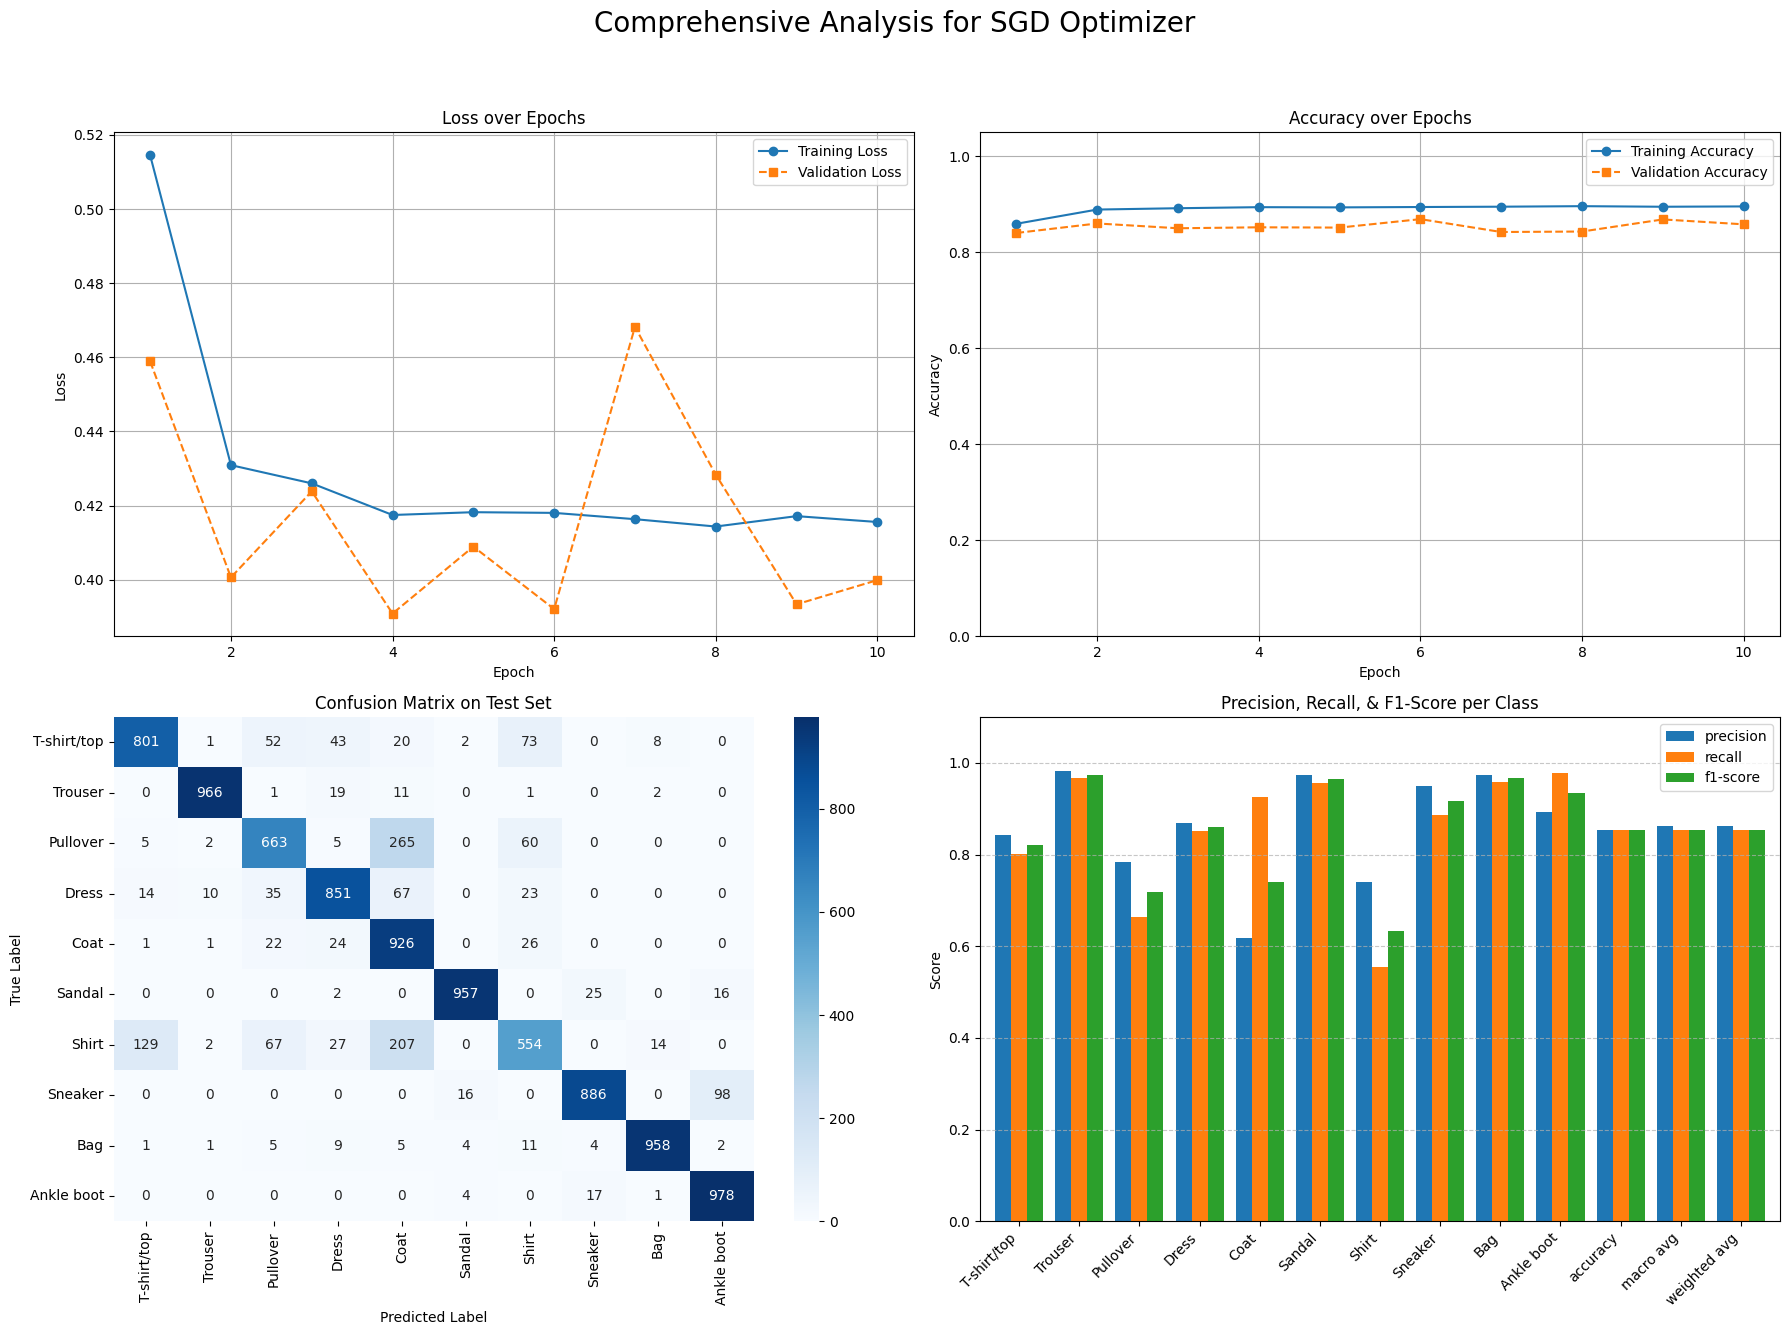


--- Text-Based Classification Report ---
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.80      0.82      1000
     Trouser       0.98      0.97      0.97      1000
    Pullover       0.78      0.66      0.72      1000
       Dress       0.87      0.85      0.86      1000
        Coat       0.62      0.93      0.74      1000
      Sandal       0.97      0.96      0.97      1000
       Shirt       0.74      0.55      0.63      1000
     Sneaker       0.95      0.89      0.92      1000
         Bag       0.97      0.96      0.97      1000
  Ankle boot       0.89      0.98      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000


==================== Full Report for: L-BFGS ====================


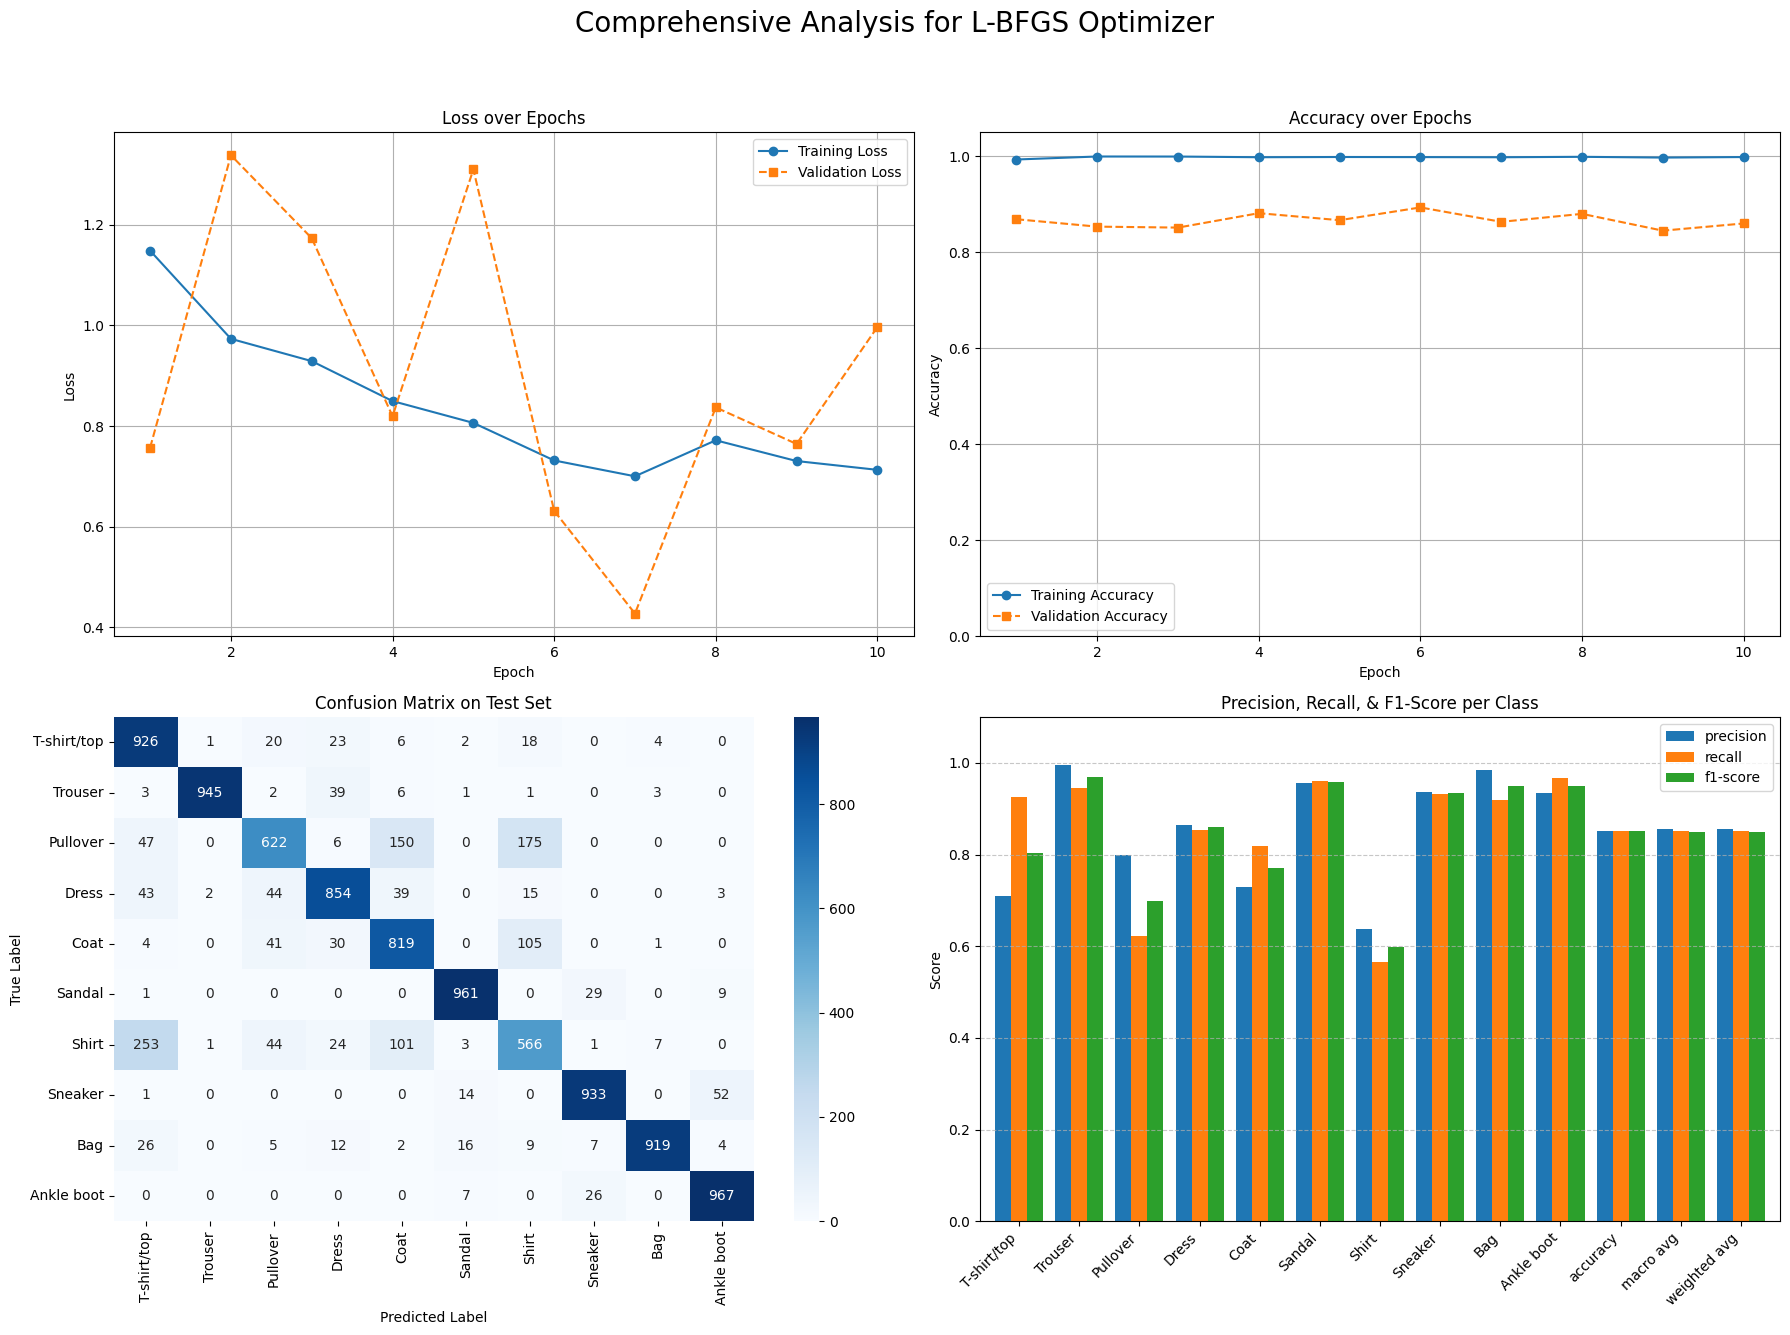


--- Text-Based Classification Report ---
              precision    recall  f1-score   support

 T-shirt/top       0.71      0.93      0.80      1000
     Trouser       1.00      0.94      0.97      1000
    Pullover       0.80      0.62      0.70      1000
       Dress       0.86      0.85      0.86      1000
        Coat       0.73      0.82      0.77      1000
      Sandal       0.96      0.96      0.96      1000
       Shirt       0.64      0.57      0.60      1000
     Sneaker       0.94      0.93      0.93      1000
         Bag       0.98      0.92      0.95      1000
  Ankle boot       0.93      0.97      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


==================== Full Report for: GA ====================


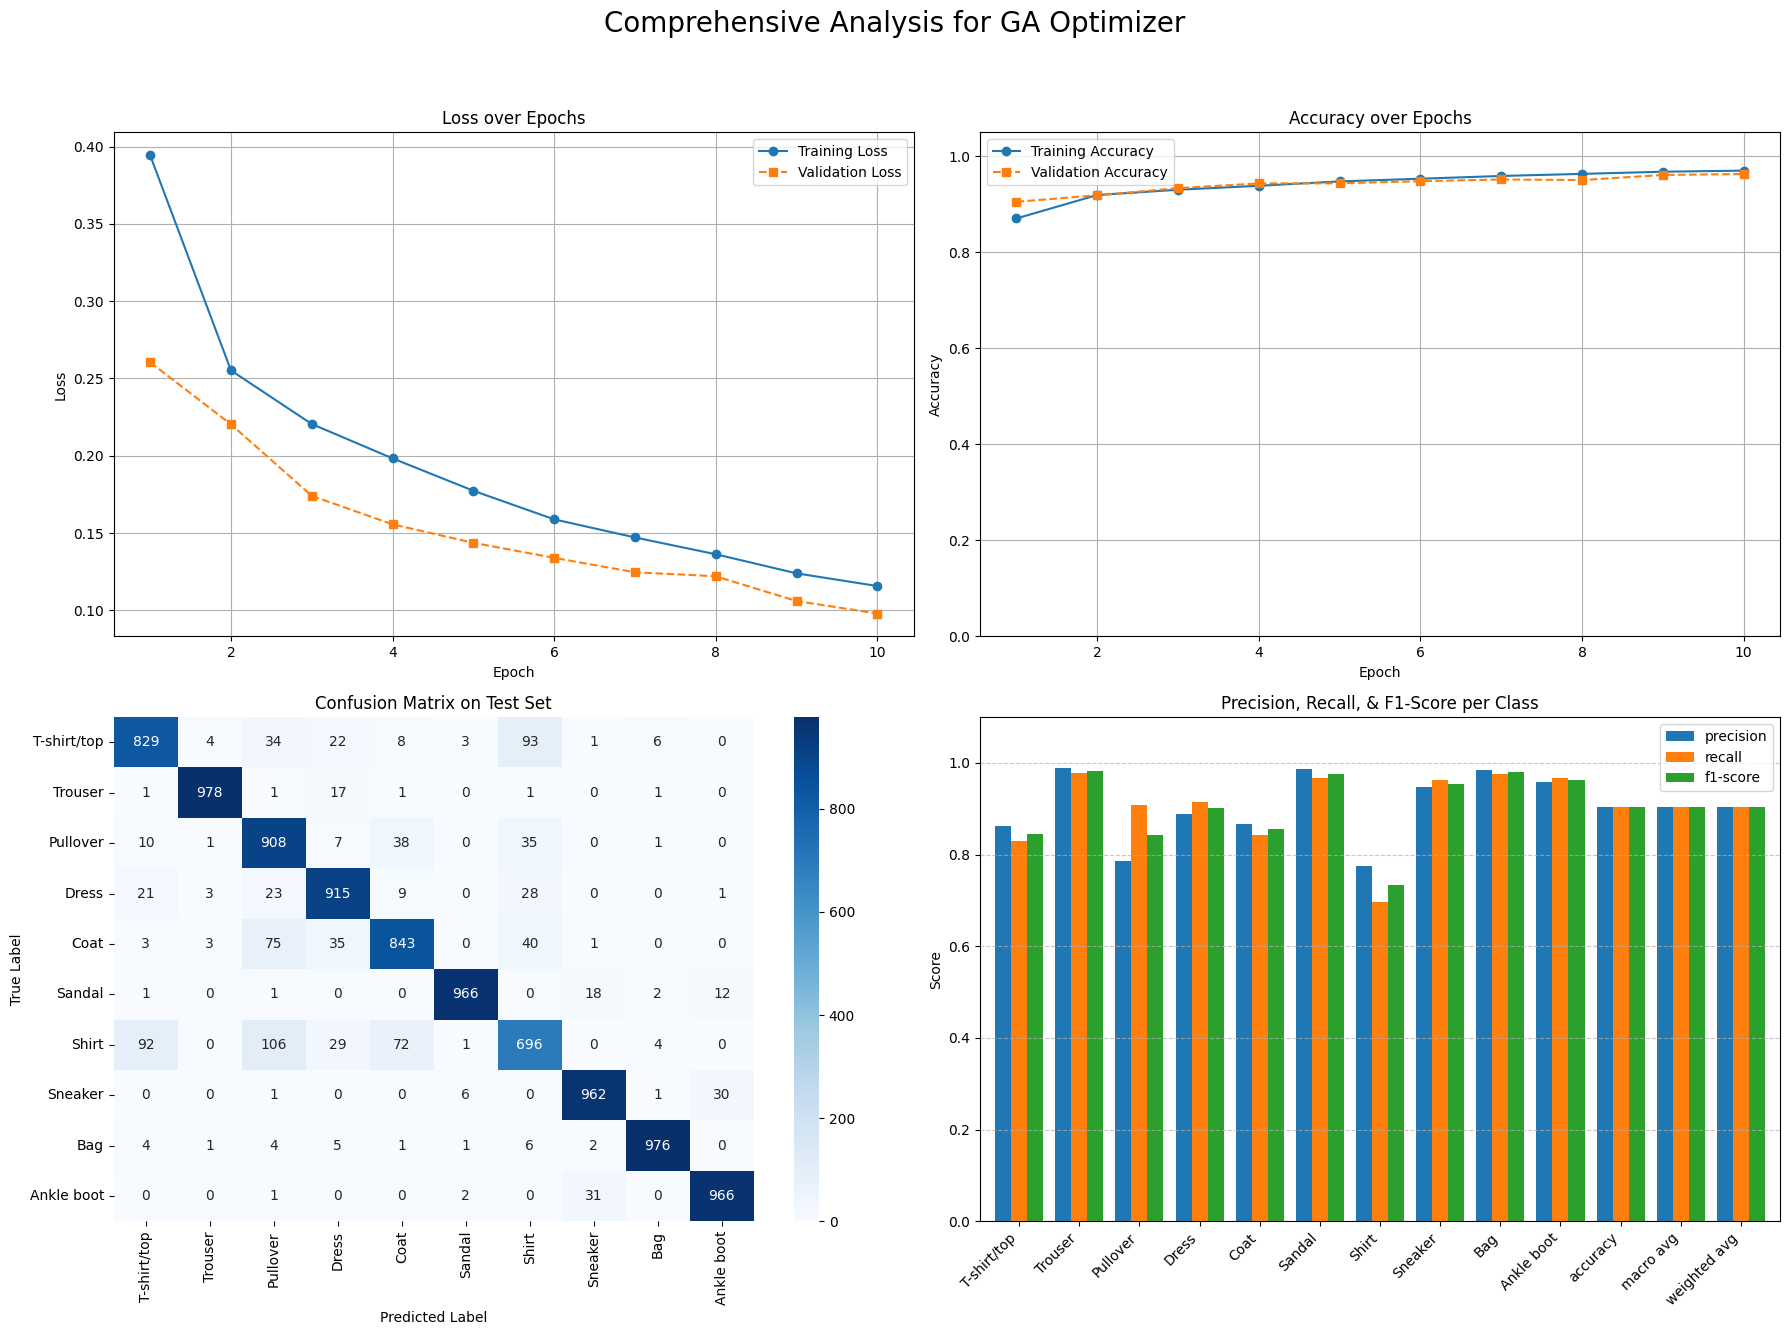


--- Text-Based Classification Report ---
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.83      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.79      0.91      0.84      1000
       Dress       0.89      0.92      0.90      1000
        Coat       0.87      0.84      0.85      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.77      0.70      0.73      1000
     Sneaker       0.95      0.96      0.95      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.96      0.97      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


==================== Full Report for: PSO ====================


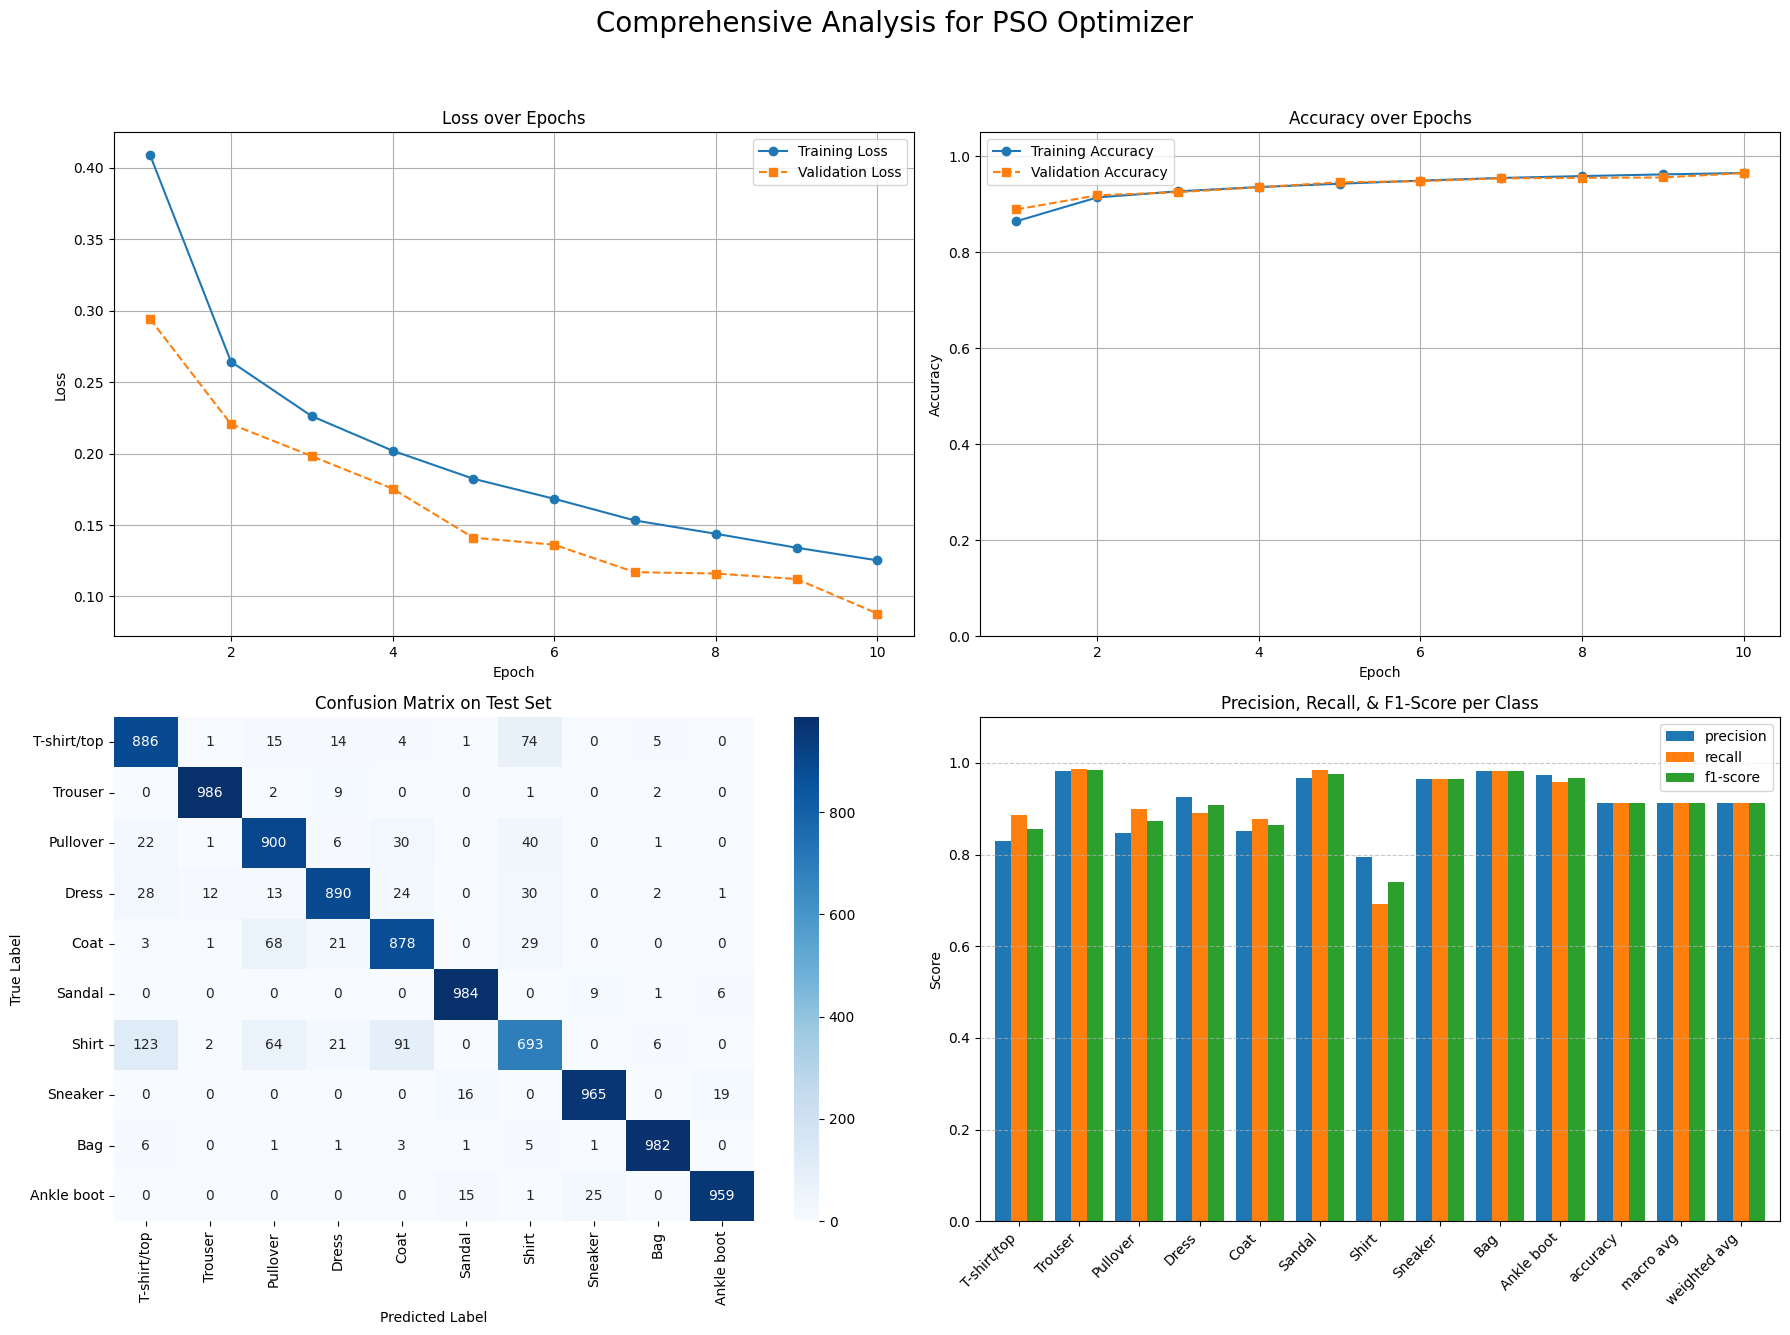


--- Text-Based Classification Report ---
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.89      0.86      1000
     Trouser       0.98      0.99      0.98      1000
    Pullover       0.85      0.90      0.87      1000
       Dress       0.93      0.89      0.91      1000
        Coat       0.85      0.88      0.87      1000
      Sandal       0.97      0.98      0.98      1000
       Shirt       0.79      0.69      0.74      1000
     Sneaker       0.96      0.96      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



--- Generating Comparative Plots ---


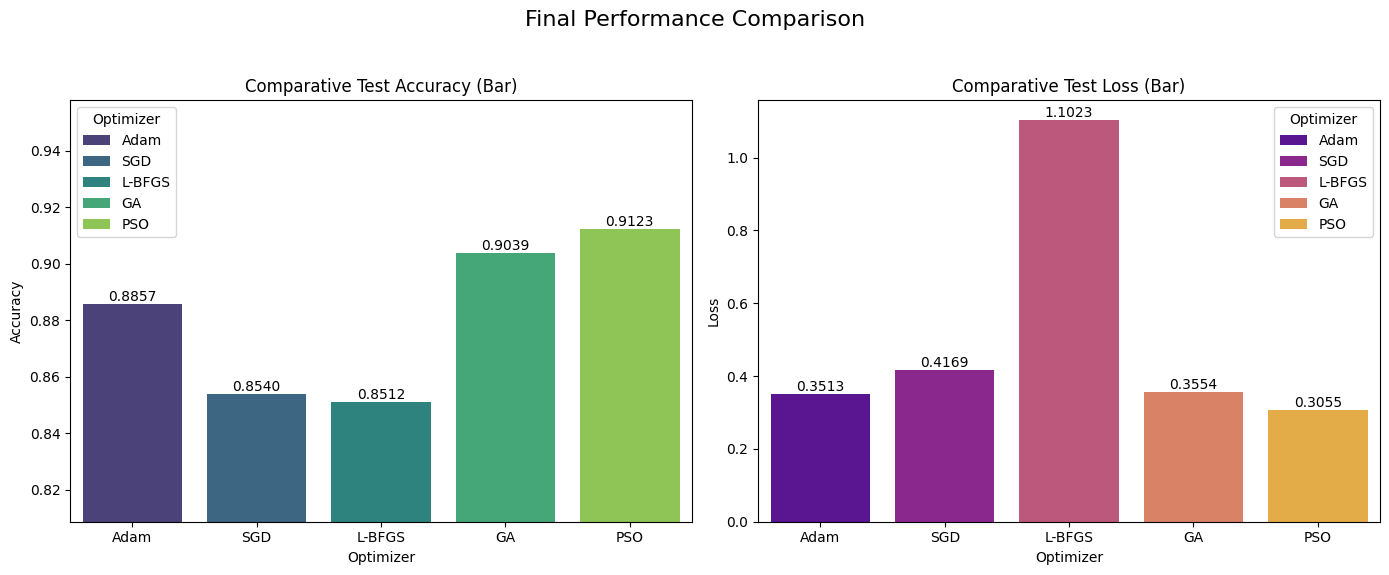

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

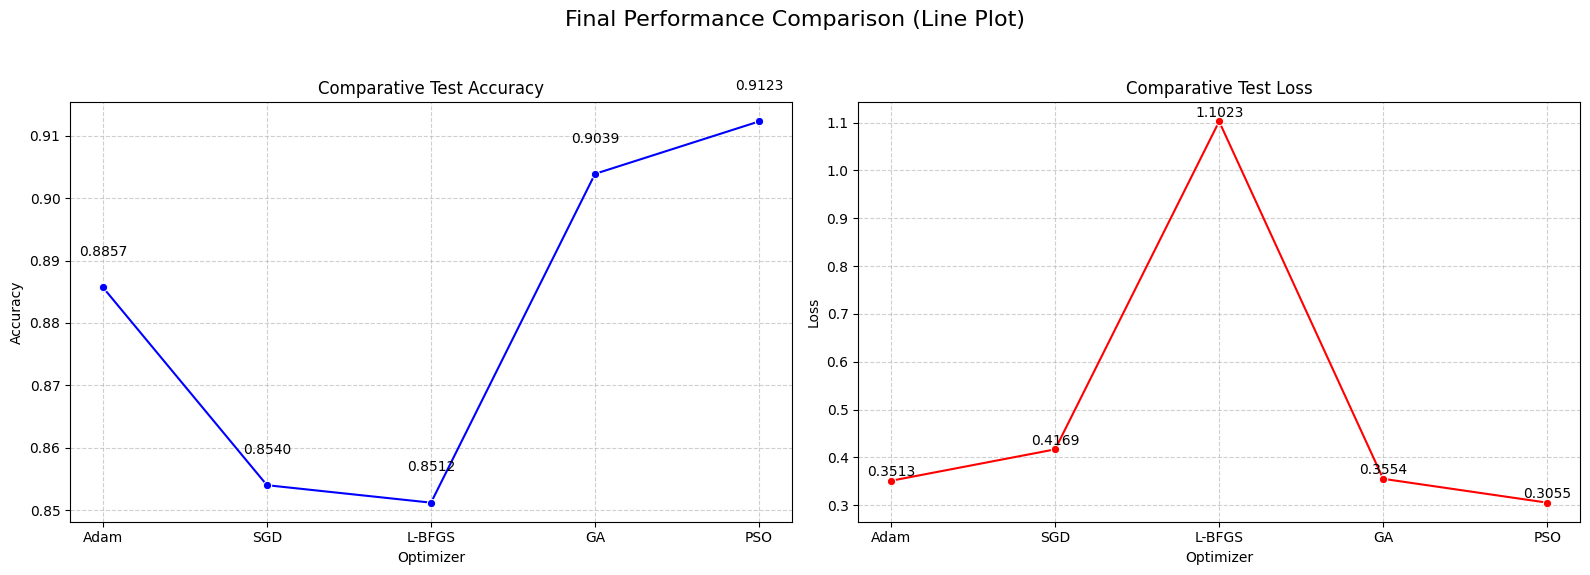

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

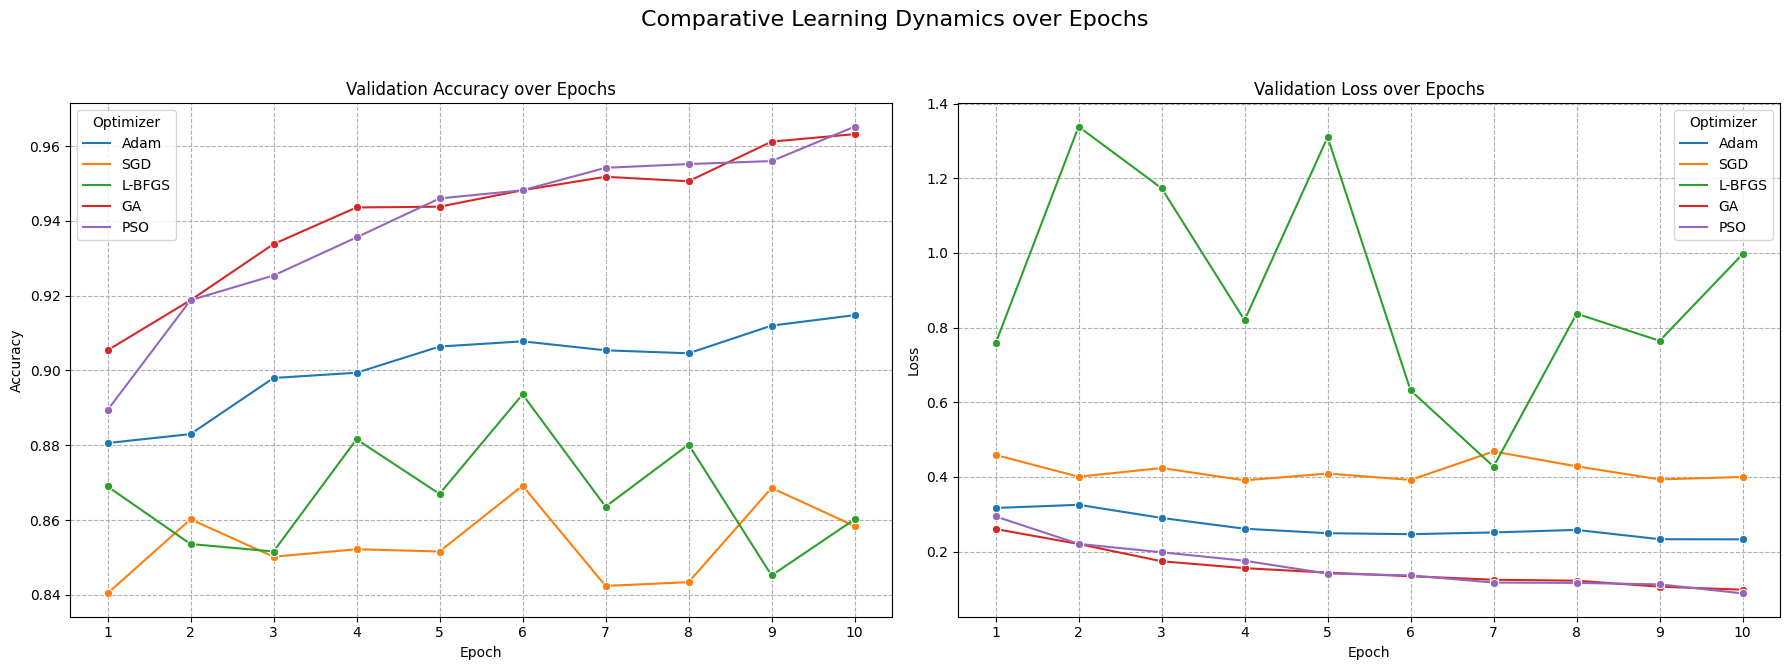

In [ ]:
if __name__ == "__main__":
    # --- Step 1: Run all experiments and store results ---
    results_archive = {}

    results_archive['Adam'] = run_adam_experiment()
    results_archive['SGD'] = run_sgd_experiment()
    results_archive['L-BFGS'] = run_lbfgs_experiment()
    results_archive['GA'] = run_ga_experiment()
    results_archive['PSO'] = run_pso_experiment()

    print("\n✅ All experiments complete. Generating reports and plots...")

    # --- Step 2: Generate all plots and reports ---

    # Generate the comprehensive, individual report for each optimizer
    print("\n\n--- Generating Individual Optimizer Reports ---")
    generate_individual_optimizer_reports(results_archive)

    # Generate plots that compare all optimizers with each other
    print("\n\n--- Generating Comparative Plots ---")
    plot_comparative_results(results_archive)
    plot_comparative_lines(results_archive)
    plot_all_learning_curves_combined(results_archive)